<a href="https://colab.research.google.com/github/InsightofSPb/PyTorch_Study/blob/main/CNN/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель работы:** изучить процесс классификации цветов с помощью свёрточной нейронной сети на примере данных с kaggle.

**Задачи:**
*   Изучить библиотеки TensorFlow-Keras, torch-torchvision, NumPy и Matplotlib.
*   Загрузить и предобработать данные.
*   Разбить данные на обучающую и проверочную выборки.
*   Определить архитектуру свёрточной нейронной сети.
*   Обучить модель на обучающей выборке.
*   Оценить качество модели на проверочной выборке.

*   Подобрать оптимальные гиперпараметры модели на основе результатов на проверочной выборке.

*   Протестировать модель на проверочной (тестовой) выборке.
*   Построить графики, чтобы проанализировать процесс обучения и оценки качества модели на обучающей, проверочной выборках.



Ход работы:
В датасете не так много картинок, чуть больше 4000 тысяч. Для более качественного обучения свёрточной нейронной сети можно провести процедуру аугментации, то есть увеличить выборку данных через модификацию существующих данных.\
Для этого можно в отдельном файле поочередно для каждого класса, а всего у нас их 5, выполнить следующую последовательность действий:\
Загрузим необходимые библиотеки.

In [ ]:
import torch
import numpy as np
import os
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image


Создадим экземпляр класса Compose для последующей нормализации данных.\
Здесь приводим все картинки к одному размеру, переводим их в формат тензоров и нормализуем по каждому каналу:


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),  # приводим картинки к одному размеру
        torchvision.transforms.ToTensor(),  # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]  # нормализуем картинки по каналам
        ),
    ]
)


Далее создадим ещё один объект класса Compose. только с дополнительными преобразованиями:

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2)
])


Здесь:
- transforms.RandomHorizontalFlip(p=0.5) выполняет случайное зеркальное отражение изображения по горизонтали.
- transforms.RandomVerticalFlip(p=0.5) выполняет случайное зеркальное отражение изображения по вертикали.
- transforms.RandomRotation(degrees=10) выполняет случайное поворот изображения на угол, заданный в градусах.
- transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)) выполняет аффинное преобразование, включающее случайный поворот, масштабирование и сдвиг изображения.
- transforms.RandomPerspective(distortion_scale=0.2) выполняет перспективное преобразование на основе случайного искажения изображения.

Далее создаём датасет, для которого лейблами, то есть классами, будут выступать имена папок:

In [ ]:
path = os.getcwd()
datapath = os.path.join(path, "flowers")
dataset = ImageFolder(datapath, transform=prepare_imgs)  # создаём датасет на основе папки и применяет трансформацию
print(f'Всего элементов: {len(dataset.samples)}, всего классов: {len(dataset.classes)}')


Наконец, применяем преобразование к элементам исходного датасета:

In [ ]:
for j in range(730):
    new_image = transform(dataset[3333 + j][0])
    torchvision.utils.save_image(new_image,f'image{5}{j+1}.jpg')


Здесь длину цикла можно меня в зависимости от размера папки с образцами. После этого можно добавить сгенерированные образцы в соответствующие папки, получив тем самым больше данных.

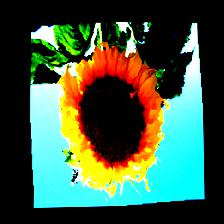

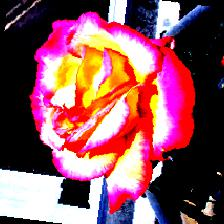

Теперь приступим к основному файлу. Импорт библиотек.

In [ ]:
import torch
import numpy as np
import os
import torch
import torchvision
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


Пропишем код для проверки наличия GPU и зададим инициализационное значение для псевдогенератора случайных чисел

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)


Создадим экземпляр класса Compose для последующей нормализации данных.

In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),  # приводим картинки к одному размеру
        torchvision.transforms.ToTensor(),  # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]  # нормализуем картинки по каналам
        ),
    ]
)


Далее создаём датасет, для которого лейблами, то есть классами, будут выступать имена папок:

In [ ]:
path = os.getcwd()
datapath = os.path.join(path, "flowers")
dataset = ImageFolder(datapath, transform=prepare_imgs)
print(f'Всего элементов: {len(dataset.samples)}, всего классов: {len(dataset.classes)}')


Разделение выборки на тренировочную и валидационную 
в нашем случае валидационная == тестовой

In [ ]:
test = 0.15  # размер тестовой выборки
batch_size = 16  # размер порции данных (батча)

test_split = int(len(dataset) * test)
train_split = len(dataset) - test_split
generator = torch.Generator().manual_seed(42)  # генератор случайного разделения на тестовую и обучающую выборки
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_split, test_split], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # делит на батчи данные
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

**Создание класса модели**\
В модели используются следующие слои: свёрточный (3 - 64), свёрточный (64 - 64), пуллинг по максимальному значению (2,2), свёрточный (64 - 128), свёрточный (128 - 256), усреднённый пуллинг и за ним максимальный пуллинг, дальше свёрточный (256 - 512), усреднённый и максимальный, два линейных (36 * 512 - 512) и (512 - 5). Функции активации - ReLU

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 3 - 64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 64 - 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64 - 128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 128 - 256
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # усреднённый пуллинг
            nn.MaxPool2d(kernel_size=3, stride=2),  # максимальный пуллинг
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # 256 - 512
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.lin1 = nn.Linear(6 * 6 * 512, 512)   # 18432 - 512
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(512, 5)   # переходим к классам


    def forward(self, x):
        # print(f'Вход: {x.shape}')
        x = self.layer1(x)
        # print(f'Первый слой выход: {x.shape}')
        x = self.layer2(x)
        # print(f'Второй слой выход: {x.shape}')
        x = self.layer3(x)
        # print(f'Третий слой выход: {x.shape}')
        x = nn.Flatten()(x)
        x = self.lin1(x)
        # print(f'1 линейный слой выход: {x.shape}')
        x = self.relu1(x)
        x = self.lin2(x)
        return x

Создаём экземплеяр нашего класса модели, переводим его на GPU. В качестве функции потерь выступает функция кросс-энетропии, в качестве оптимизатора - стохастический градиентный спукт, скорость обучения = 0.01

In [ ]:
model = CNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

**Обучение модели и вычисление метрик**\
В каждой эпохе для каждой порции данных (батча) выполняем классический прямой проход модели, вычисление функции потерь, обнуление градиентов, обратный проход и корректировку значений.\

Вычисляем точность, f1-меру, выводим в процессе обучения и тестирования

In [ ]:
f1_tr, acc_tr, loss_tr, f1_te, acc_te, loss_te = [], [], [], [], [], []  # задаём пустые списки для будущих метрик

epochs = 60

for epoch in range(epochs):
    train_loss = 0
    y_true = []
    y_pred = []
    model.train()   # вычисляет градиенты
    for X, y in train_dataloader:  # для каждого батча
        X, y = X.to(device), y.to(device)
        pred = model(X)   # прямой проход

        loss = loss_fn(pred, y)  # функция потерь

        optimizer.zero_grad()  # обнуление градиентов
        loss.backward()  # обратный проход
        optimizer.step()

        train_loss += loss.item() * y.size(0)
        _, predicted = torch.max(pred.data, 1)
        y_true.extend(y.tolist())
        y_pred.extend(predicted.tolist())
        if len(y_true) % 4000 == 0:
            print(f'Прошло {len(y_true)} образцов в эпохе {epoch + 1}')
    train_loss = train_loss / len(train_dataloader)
    loss_tr.append(train_loss)
    f1_tr.append(f1_score(y_true, y_pred, average='macro'))
    acc_tr.append(accuracy_score(y_true, y_pred))
    trainTemplate = "epoch: {} | train loss: {:.3f} | train accuracy: {:.3f} | train f1: {:.3f}"
    print(trainTemplate.format(epoch + 1, train_loss, acc_tr[-1], f1_tr[-1]))

    model.eval()  # уже не вычисляет градиенты, что экономит память
    with torch.inference_mode():
        test_loss = 0
        y_true = []
        y_pred = []
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            print(pred)
            print(torch.max(pred.data))

            test_loss += loss.item() * y.size(0)
            _, predicted = torch.max(pred.data, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())
        test_loss = test_loss / len(test_dataloader)
        loss_te.append(test_loss)
        f1_te.append(f1_score(y_true, y_pred, average='macro'))
        acc_te.append(accuracy_score(y_true, y_pred))
        testTemplate = "epoch: {} | test loss: {:.3f} | test accuracy: {:.3f} | test f1: {:.3f}"
        print(testTemplate.format(epoch + 1, test_loss, acc_te[-1], f1_te[-1]))

Функция для построения графиков для тестовой и тренировочной метрики

In [ ]:
def plot_help(epochs, y_train_m, y_test_m, title, path):
    plt.rc('lines', linewidth=2.5)
    fig, ax = plt.subplots()
    ax.set_title(title)
    line1, = ax.plot(np.linspace(1, epochs, num=epochs), y_train_m, label='train')   # ось Ох, эпохи
    line1.set_dashes([10, 2, 2, 2])  # 10pt line, 2pt break, 2pt line, 2pt break.   # для прерывистой линии
    line1.set_dash_capstyle('round')  # размер маркеров и их форма
    ax.scatter(np.linspace(1, epochs, num=epochs), y_train_m)
    line2, = ax.plot(np.linspace(1, epochs, num=epochs), y_test_m, label='test')
    ax.scatter(np.linspace(1, epochs, num=epochs), y_test_m)
    ax.legend(handlelength=4)
    plt.grid()
    plt.savefig(os.path.join(path, f'{title}.png'))
    return fig, ax


title = 'F1 Scores over Epochs'
fig1, ax1 = plot_help(epochs, f1_tr, f1_te, title, path)
title = 'Loss over Epochs'
fig2, ax2 = plot_help(epochs, loss_tr, loss_te, title, path)
title = 'Accuracy over Epochs'
fig3, ax3 = plot_help(epochs, acc_tr, acc_te, title, path)

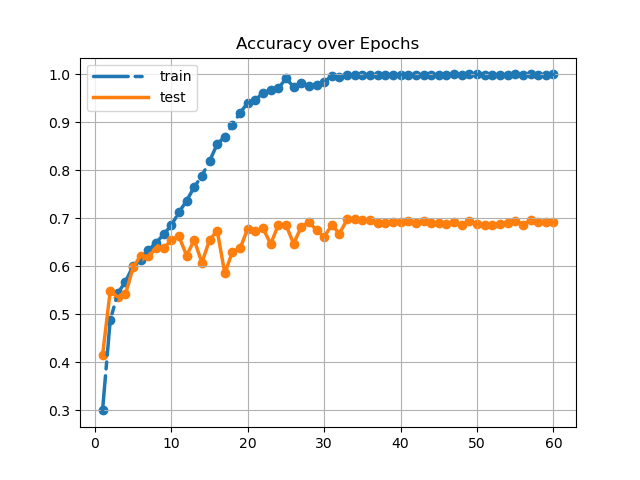

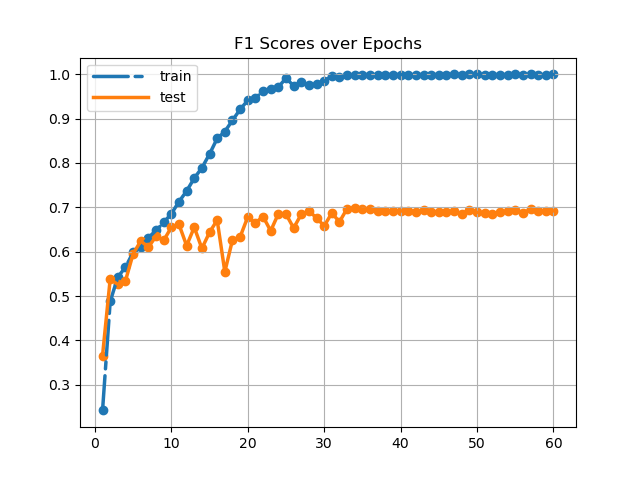

Сохраняем модель

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
from torchvision import models

alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')

**Выводы:**

В ходе выполнения работы была проведена аугментация изображений. Также была построена модель свёрточной нейронной сети, состоящей из 5 свёрточных слоёв, 2 слоёв усреднённого пуллинга, 3 слоёв максимального пуллинга и двух линейных слоёв.\
Построены графики для точности и f1-меры для обучающей и тестовой выборок, где видно, что для тестовой выборки точность не более 70%, однако, как показала практика, этот показатель можно было бы увеличить, если увеличить датасет.

*В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?*

- у СНН используются свёрточные слои и слои для пуллинга, позволяющие уменьшить размерность входных данных
- у СНН меньше параметров, что позволяет эффективнее рассчитывать
- на разных уровнях и этапах свёртки сеть может находить определённые паттерны - крупные или наоборот, более детализированные

